In [54]:
from pymc_extras.statespace import structural as st
from pymc_extras.statespace.utils.constants import SHORT_NAME_TO_LONG, MATRIX_NAMES
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import numpy as np
import pandas as pd
from patsy import dmatrix

plt.rcParams.update(
    {
        "figure.figsize": (14, 4),
        "figure.dpi": 144,
        "figure.constrained_layout.use": True,
        "axes.grid": True,
        "grid.linewidth": 0.5,
        "grid.linestyle": "--",
        "axes.spines.top": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "axes.spines.right": False,
    }
)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=8,
        draws=100,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

In [55]:
from pymc_extras.statespace.filters.kalman_filter import StandardFilter
from pymc_extras.statespace.filters.kalman_smoother import KalmanSmoother
from pymc_extras.statespace.filters.distributions import LinearGaussianStateSpace
from pymc.pytensorf import inputvars, compile_pymc


def make_numpy_function(mod):
    mod = mod.build(verbose=False)
    data = pt.matrix("data", shape=(None, 1))
    steps = pt.iscalar("steps")
    x0, _, c, d, T, Z, R, H, Q = mod._unpack_statespace_with_placeholders()
    sequence_names = [x.name for x in [c, d] if x.ndim == 2]
    sequence_names += [x.name for x in [T, Z, R, H, Q] if x.ndim == 3]

    rename_dict = {v: k for k, v in SHORT_NAME_TO_LONG.items()}
    sequence_names = list(map(rename_dict.get, sequence_names))

    P0 = pt.zeros((x0.shape[0], x0.shape[0]))
    outputs = LinearGaussianStateSpace.dist(
        x0, P0, c, d, T, Z, R, H, Q, steps=steps, sequence_names=sequence_names
    )
    inputs = inputvars(outputs)

    _f = compile_pymc(inputs, list(outputs), on_unused_input="ignore")

    def f(*, draws=1, **params):
        steps = params.pop("steps")
        output = [np.empty((draws, steps + 1, x.type.shape[-1])) for x in outputs]
        for i in range(draws):
            draw = _f(**params, steps=steps)
            for j, x in enumerate(draw):
                output[j][i] = x
        return [x.squeeze() for x in output]

    return f

In [56]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

y = train_df.sum(axis=1)[20:120]
y.index = pd.to_datetime(y.index)
y.index.freq = y.index.inferred_freq

y_train = y[:-10]

<Axes: xlabel='Date_Symptoms'>

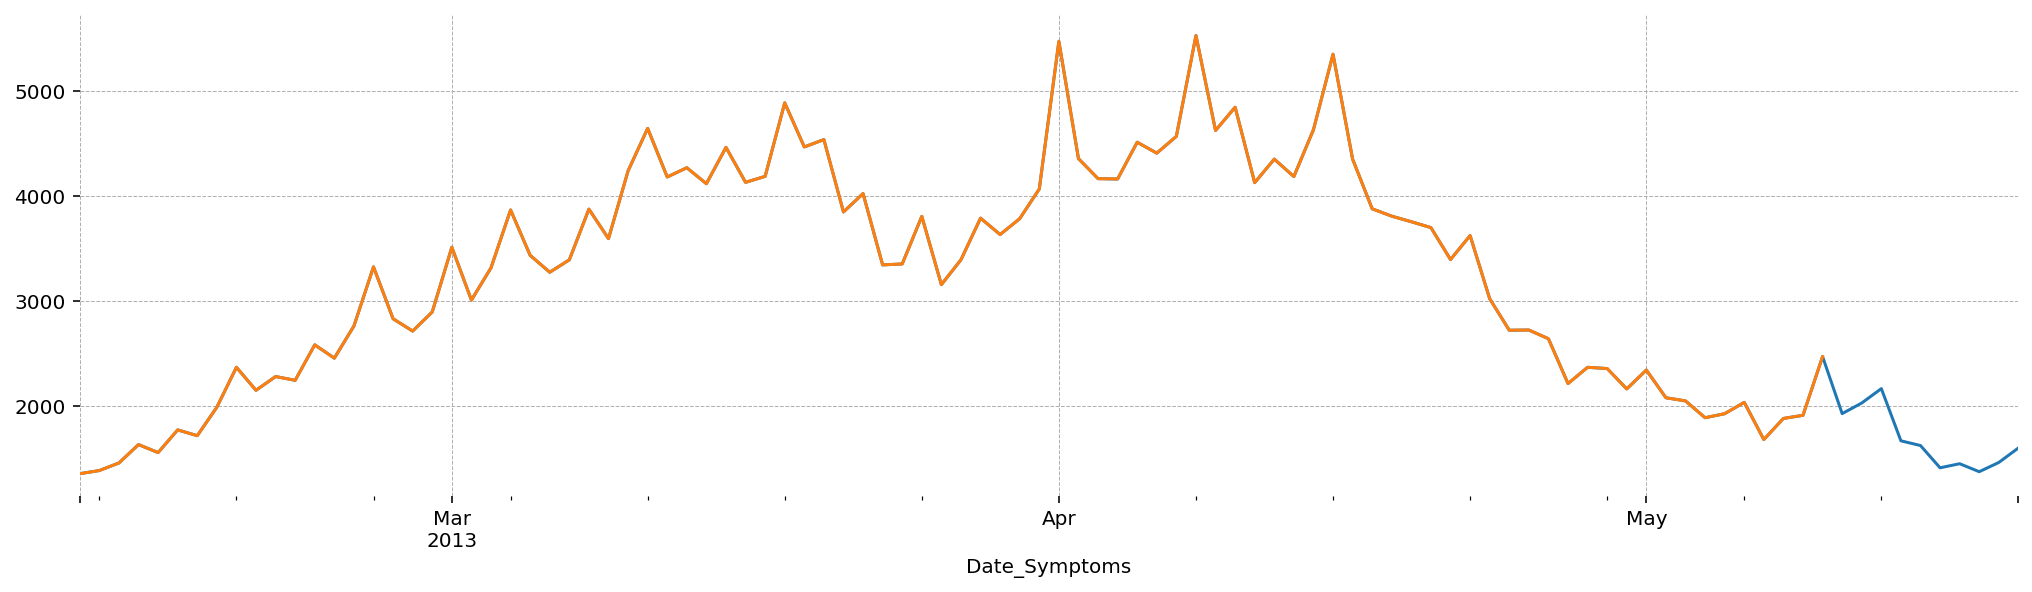

In [57]:
y.plot()
y_train.plot()

In [58]:
ll = st.LevelTrendComponent(order=2)
se1 = st.FrequencySeasonality(season_length=7, name="weekly")
se2 = st.FrequencySeasonality(season_length=3.5, name="bi_weekly")

mod = ll + se1 + se2
ss_mod = mod.build()

                               Model Requirements                               
                                                                                
  Variable          Shape      Constraints                          Dimensions  
 ────────────────────────────────────────────────────────────────────────────── 
  initial_trend     (2,)                                      ('trend_state',)  
  sigma_trend       (2,)       Positive                       ('trend_shock',)  
  weekly            (6,)                                     ('weekly_state',)  
  sigma_weekly      ()         Positive                                   None  
  bi_weekly         (2,)                                  ('bi_weekly_state',)  
  sigma_bi_weekly   ()         Positive                                   None  
  P0                (10, 10)   Positive semi-definite   ('state', 'state_aux')  
                                                                                
  These parameters should be assigned priors inside a PyMC model block before   
                   calling the build_statespace_graph method.                   

In [59]:
initial_trend_dims, sigma_trend_dims, weekly_dims, bi_weekly_dims, P0_dims = ss_mod.param_dims.values()
coords = ss_mod.coords

In [ ]:
with pm.Model(coords=coords) as model_2:
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=1, dims=P0_dims[0])
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=P0_dims)
    initial_trend = pm.Normal("initial_trend", sigma=[100, 1], dims=initial_trend_dims)

    weekly_seasonal = pm.ZeroSumNormal("weekly", sigma=100, dims=weekly_dims)
    bi_weekly_seasonal = pm.ZeroSumNormal("bi_weekly", sigma=100, dims=bi_weekly_dims)

    sigma_trend = pm.Gamma("sigma_trend", alpha=2, beta=[1, 10], dims=sigma_trend_dims)
    sigma_monthly_season = pm.Gamma("sigma_weekly", alpha=2, beta=1)
    sigma_monthly_season = pm.Gamma("sigma_bi_weekly", alpha=2, beta=1)

    ss_mod.build_statespace_graph(y_train, mode="JAX")

    idata = pm.sample(**sampler_kwargs())

ValueError: Incompatible Elemwise input shapes [(2,), (90,)]

In [61]:
post = ss_mod.sample_conditional_posterior(idata)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pytensor/link/jax/linker.py:32: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x312A7B760>), RNG(<Generator(PCG64) at 0x312A7B680>), RNG(<Generator(PCG64) at 0x312A7B5A0>), RNG(<Generator(PCG64) at 0x312A7B4C0>), RNG(<Generator(PCG64) at 0x312A7B3E0>), RNG(<Generator(PCG64) at 0x15D267E60>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Vector(float64, shape=(1,)) (of Variable Switch.0) into Type Vector(int32, shape=(1,)). You can try to manually convert Switch.0 into a Vector(int32, shape=(1,)). boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(*0-<Vector(int32, shape=(1,))>, 0.0, [False

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/r
ich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/j
ax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from 
dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in 
an error.
  warnings.warn(

In [62]:
component_idata = ss_mod.extract_components_from_idata(post)
component_states = component_idata.coords["state"].values.tolist()

Variables predicted_posterior_observed, smoothed_posterior_observed, filtered_posterior_observed do not contain all hidden states (their last dimension is not 10). They will not be present in the modified idata.


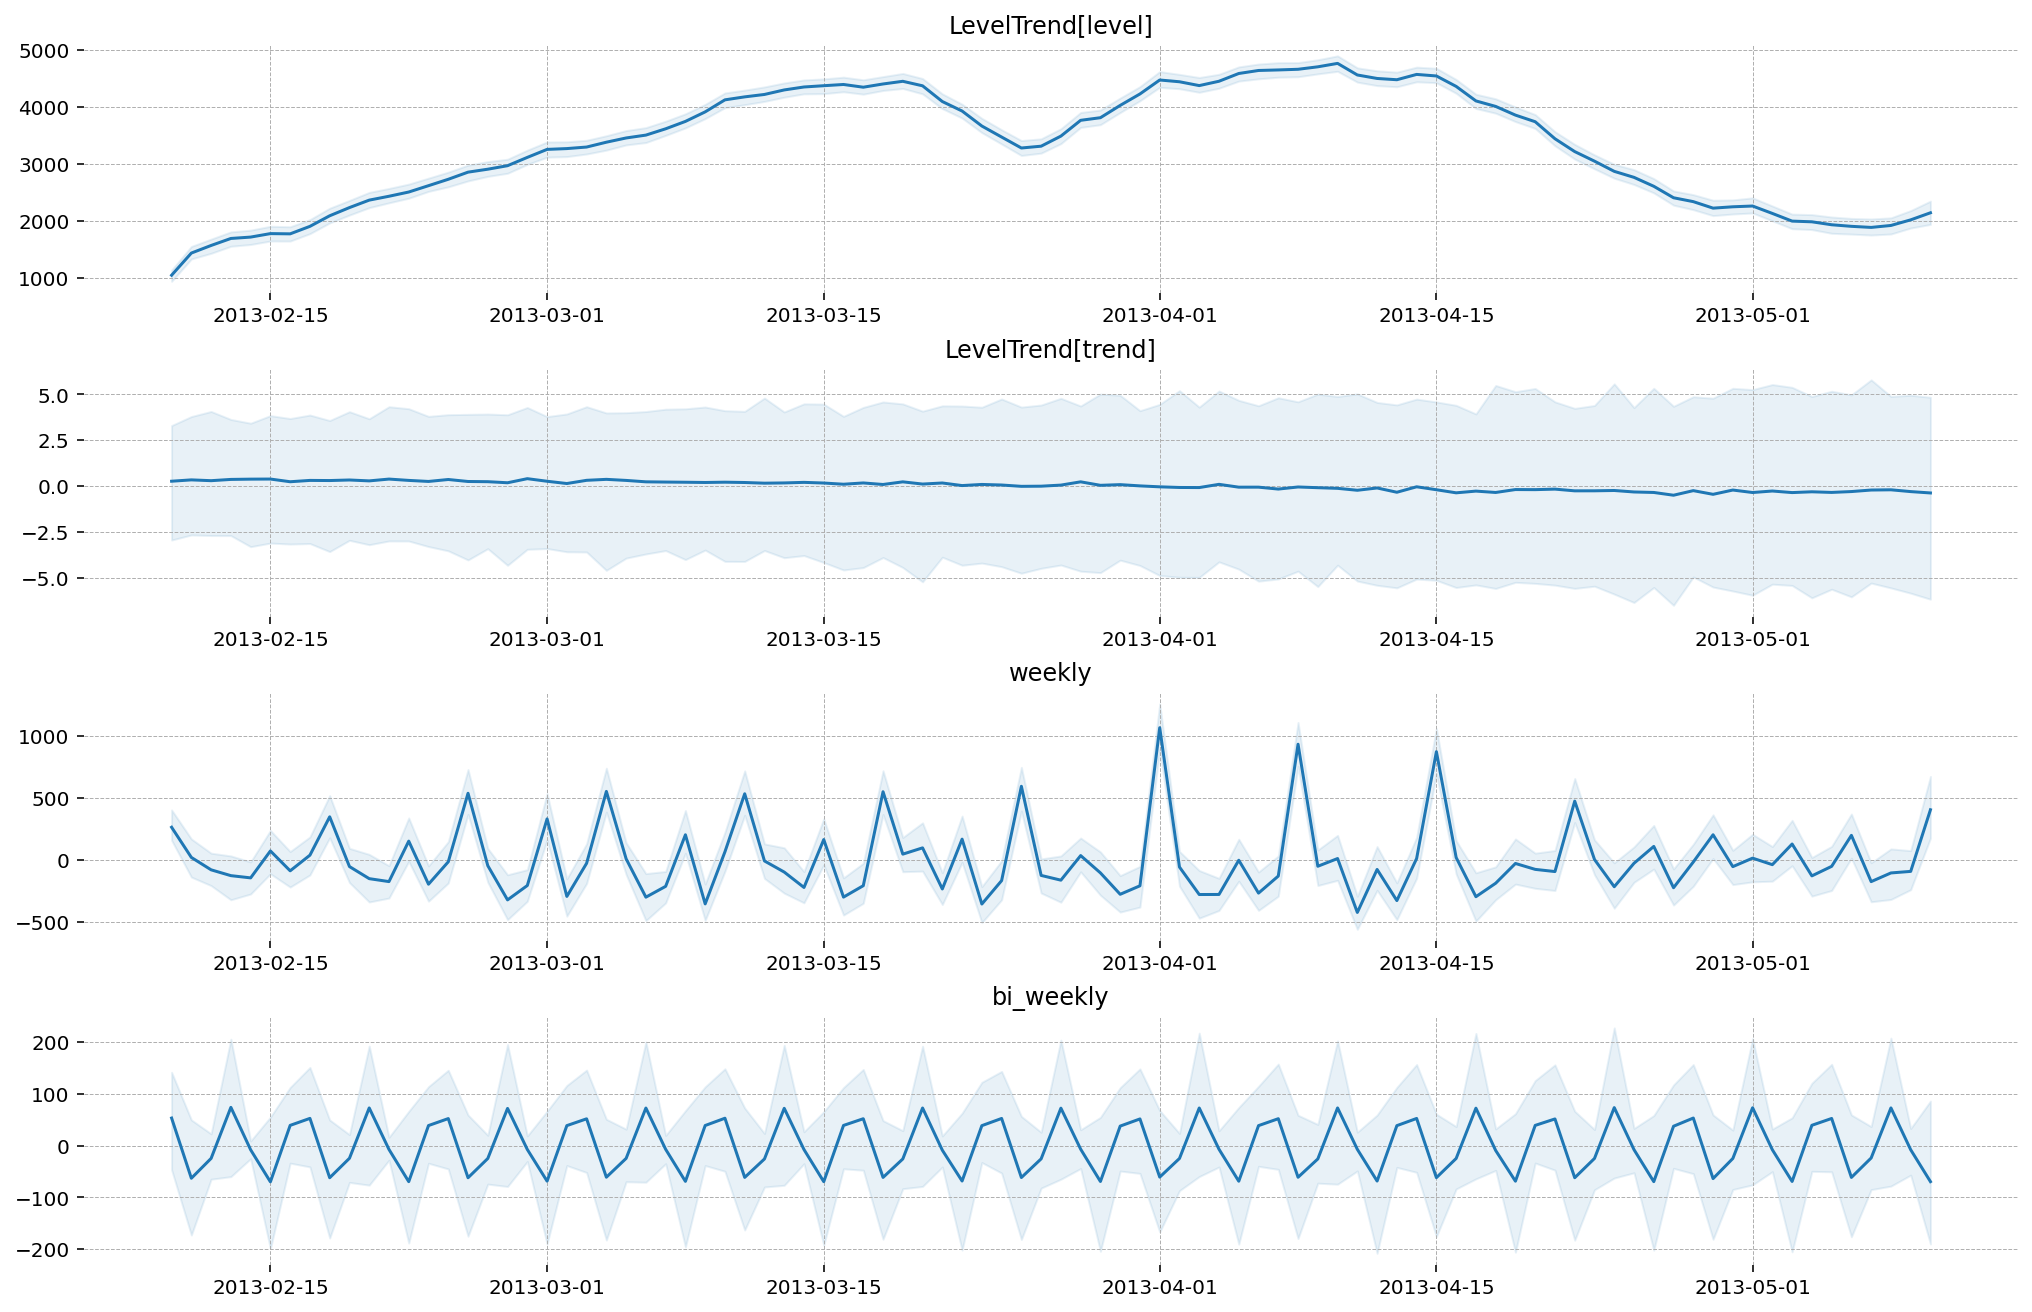

In [63]:
fig, ax = plt.subplots(4, 1, figsize=(14, 9))
x_values = component_idata.coords["time"]
for axis, name in zip(fig.axes, component_states):
    data = component_idata.smoothed_posterior.sel(state=name)
    hdi = az.hdi(data).smoothed_posterior
    mean = data.mean(dim=["chain", "draw"])

    axis.plot(x_values, mean)
    axis.fill_between(x_values, *hdi.values.T, color="tab:blue", alpha=0.1)
    axis.set_title(name)
plt.show()

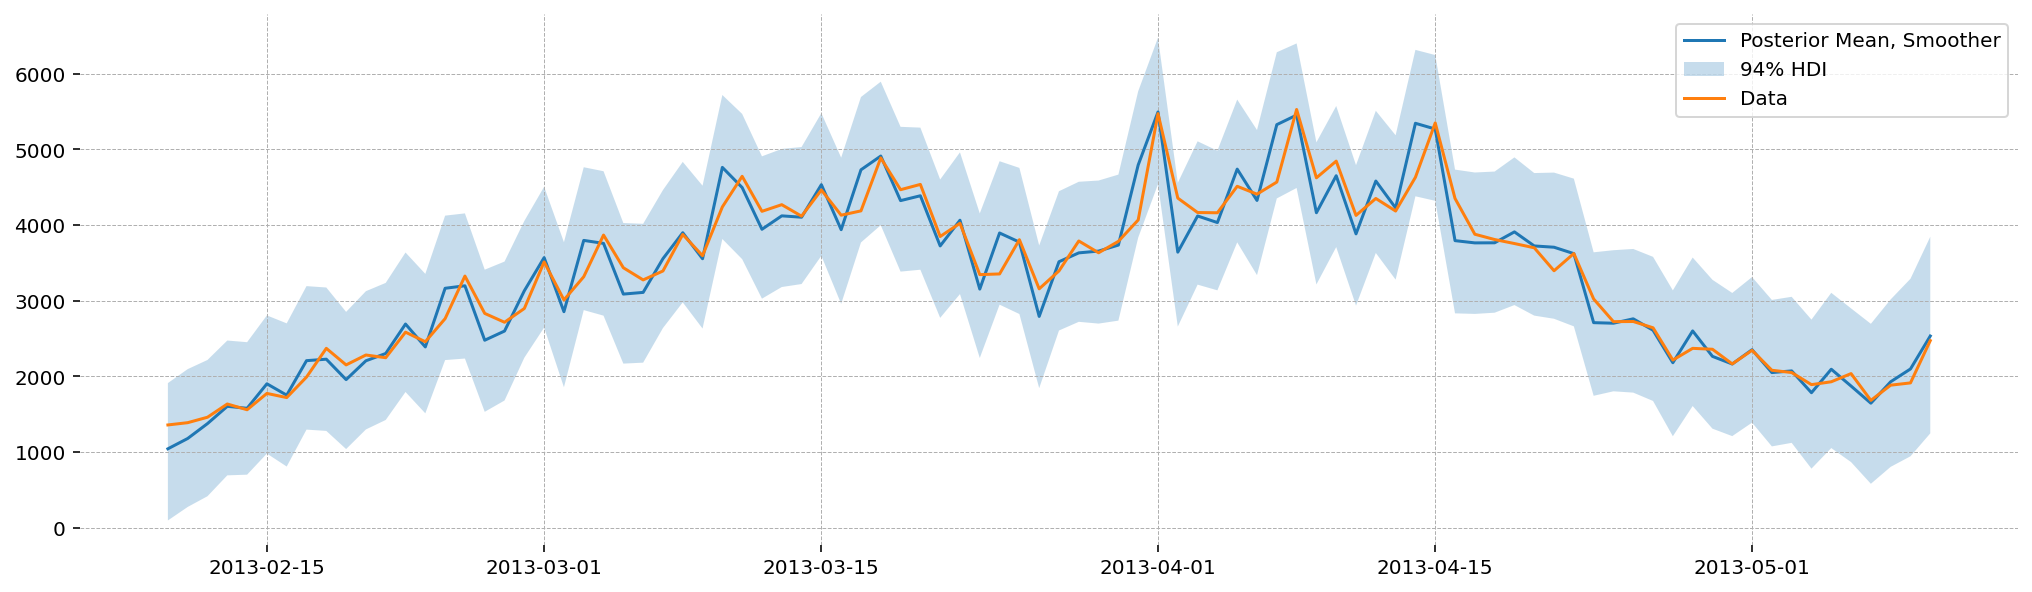

In [64]:
fig, ax = plt.subplots()
post_stacked = post.stack(sample=["chain", "draw"])
x_values = post_stacked.coords["time"]
hdi_post = az.hdi(post)
post_stacked = post.stack(sample=["chain", "draw"])

ax.plot(
    x_values,
    post_stacked.smoothed_posterior.sum(dim="state").mean(dim="sample"),
    label="Posterior Mean, Smoother",
)
ax.fill_between(
    x_values, *hdi_post.smoothed_posterior.sum(dim="state").values.T, alpha=0.25, label="94% HDI"
)
ax.plot(y_train.index, y_train.values, label="Data")
ax.legend()
plt.show()

In [65]:
forecasts = ss_mod.forecast(idata, start=y_train.index[-1], periods=10)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pytensor/link/jax/linker.py:32: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x312BFEEA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Vector(float64, shape=(1,)) (of Variable Switch.0) into Type Vector(int32, shape=(1,)). You can try to manually convert Switch.0 into a Vector(int32, shape=(1,)). boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: boolean_indexing_set_or_inc
ERROR (pytensor.graph.rewriting.basic): node: AdvancedSetSubtensor(*0-<Vector(int32, shape=(1,))>, 0.0, [False])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/r
ich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/j
ax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from 
dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in 
an error.
  warnings.warn(

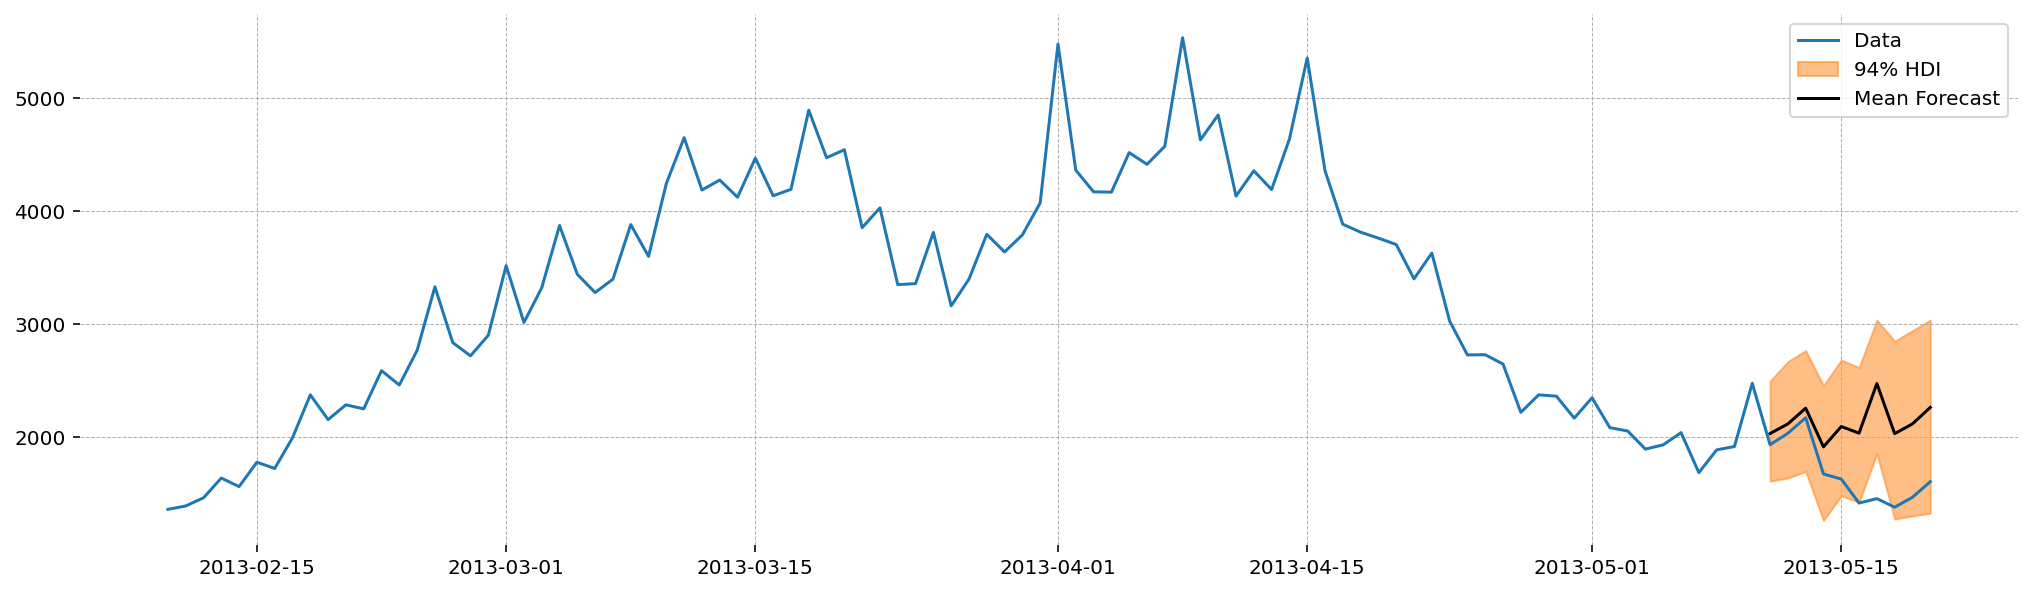

In [66]:
fig, ax = plt.subplots()
ax.plot(y.index, y, label="Data")
hdi = az.hdi(forecasts.forecast_observed.isel(observed_state=0)).forecast_observed
ax.fill_between(
    forecasts.coords["time"], *hdi.values.T, color="tab:orange", alpha=0.5, label="94% HDI"
)
ax.plot(
    forecasts.coords["time"],
    forecasts.forecast_observed.mean(dim=["chain", "draw"]).values.squeeze(),
    color="k",
    alpha=1,
    label="Mean Forecast",
)
ax.legend()
plt.show()